In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.stats import pearsonr

In [26]:
# Load JSON data from a file
def load_json_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def extract_first_numeric_value(text):
    for token in re.split(r'\s+', text):
        if token.isnumeric():
            if int(token) in range(0,11):
                return int(token)
    return None


def extract_all_values(data):
    # Dynamically identify all "name-evaluation" fields
    name_eval_fields = {
        key for item in data for key in item.keys() if "name-evaluation" in key
    }

    # Initialize dictionaries to store results
    results = {field: {"a_values": [], "values": []} for field in name_eval_fields}

    # Populate dictionaries with data
    for item in data:
        if "phrase_similarity" in item:
            phrase_similarity = item["phrase_similarity"]
            for field in name_eval_fields:
                value = extract_first_numeric_value(item.get(field))
                if value is not None:
                    results[field]["a_values"].append(phrase_similarity)
                    results[field]["values"].append(value)

    return results


def plot_name_evaluation_scatter_plots(results):
    # Define colors for each scatter plot
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'cyan', 'magenta']
    color_cycle = iter(colors)

     # Calculate the number of subplots needed
    num_plots = len(results) + 1  # +1 for the overall plot
    rows = (num_plots + 1) // 2  # Two plots per row

    fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4))
    axes = axes.flatten()
    fig.suptitle('Individual Scatter Plots of Phrase Similarity vs Judgements')

    all_a_values = []
    all_y_values = []

    def add_trendline_and_stats(ax, x, y, color, title, ylabel):
        # Plot scatter
        ax.scatter(x, y, color=color, alpha=0.7)
        
        # Calculate trendline
        m, b = np.polyfit(x, y, 1)
        trendline = m * np.array(x) + b
        ax.plot(x, trendline, color="black", linestyle="--")
        
        # Calculate and display correlation
        correlation, _ = pearsonr(x, y)
        ax.set_title(title)
        ax.set_xlabel('Phrase Similarity')
        ax.set_ylabel(ylabel)
        
        # Display trendline equation and correlation on the plot
        ax.text(0.05, 0.95, f"y = {m:.2f}x + {b:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
        ax.text(0.05, 0.90, f"r = {correlation:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')

    # Loop over each "name-evaluation" field and plot
    for i, (field, data) in enumerate(results.items()):
        color = next(color_cycle, 'gray')  # Use gray if colors run out
        a_values = data['a_values']
        y_values = data['values']

        # Collect all points for the overall trend line
        all_a_values.extend(a_values)
        all_y_values.extend(y_values)

        # Add scatter plot with trendline
        add_trendline_and_stats(axes[i], a_values, y_values, color, title=field, ylabel=f'{field} Score')

    # Plot overall trendline on the last subplot
    if len(all_a_values) > 0:
        add_trendline_and_stats(
            axes[len(results)],
            all_a_values,
            all_y_values,
            'black',
            title='Overall',
            ylabel='All Model Scores'
        )

    # Hide any unused subplots
    for j in range(len(results)+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust title spacing
    plt.show()

def plot_single_scatter(results, field_to_plot):
    if field_to_plot not in results:
        print(f"Field '{field_to_plot}' not found in results.")
        return

    data = results[field_to_plot]
    a_values = data['a_values']
    y_values = data['values']

    if not a_values or not y_values:
        print(f"No data available for field '{field_to_plot}'.")
        return

    plt.figure(figsize=(8, 6))
    plt.scatter(a_values, y_values, color='blue', alpha=0.7)

    # Calculate trendline
    m, b = np.polyfit(a_values, y_values, 1)
    trendline = m * np.array(a_values) + b
    plt.plot(a_values, trendline, color="black", linestyle="--")

    # Calculate and display correlation
    correlation, _ = pearsonr(a_values, y_values)
    plt.title(f'Scatter Plot for {field_to_plot}')
    plt.xlabel('Phrase Similarity')
    plt.ylabel(f'{field_to_plot} Score')
    plt.text(0.05, 0.95, f"y = {m:.2f}x + {b:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.05, 0.90, f"r = {correlation:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

    plt.tight_layout()
    plt.show()

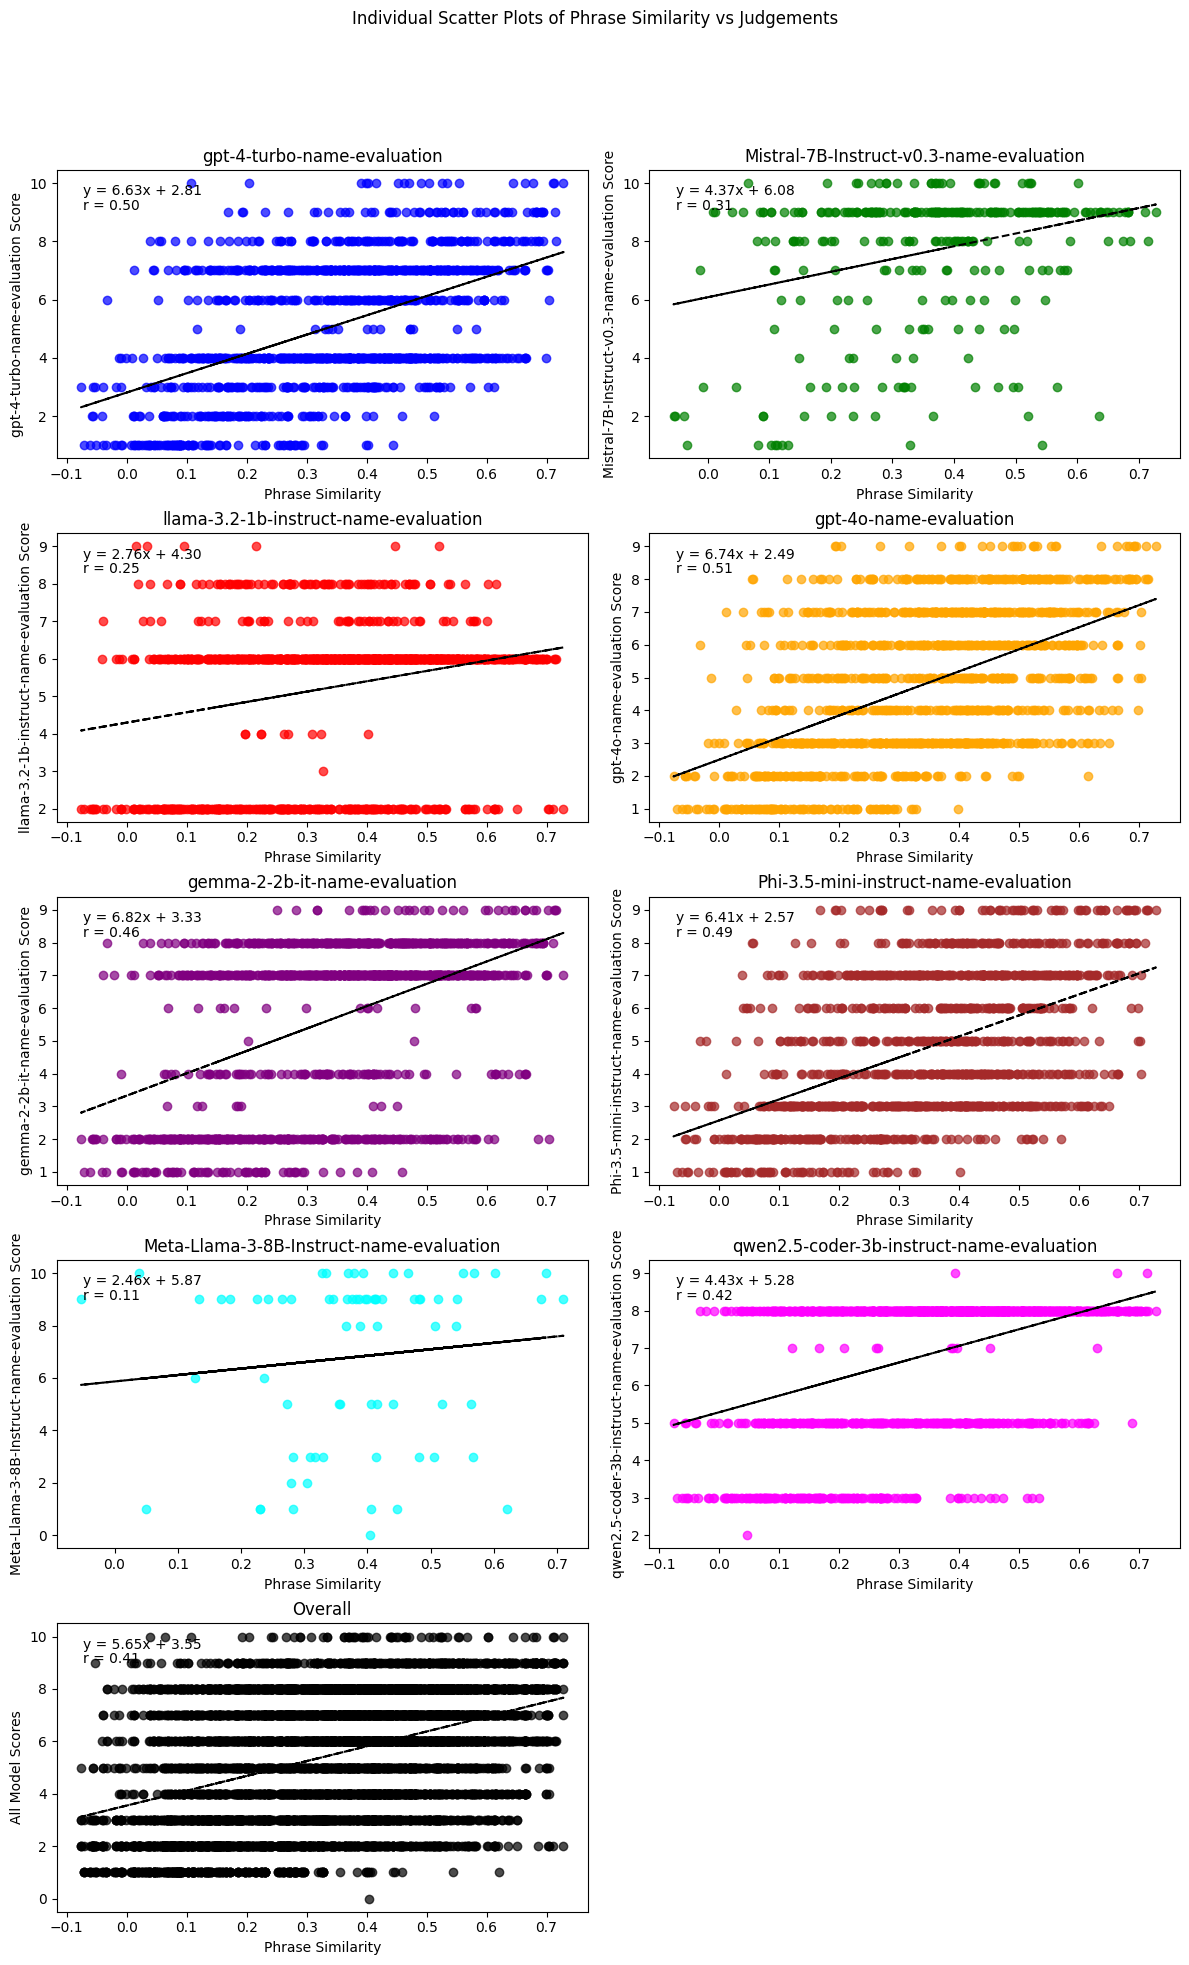

In [33]:
data = load_json_data('data_files/spider2-lite-ctesjson')
results = extract_all_values(data)
plot_name_evaluation_scatter_plots(results)

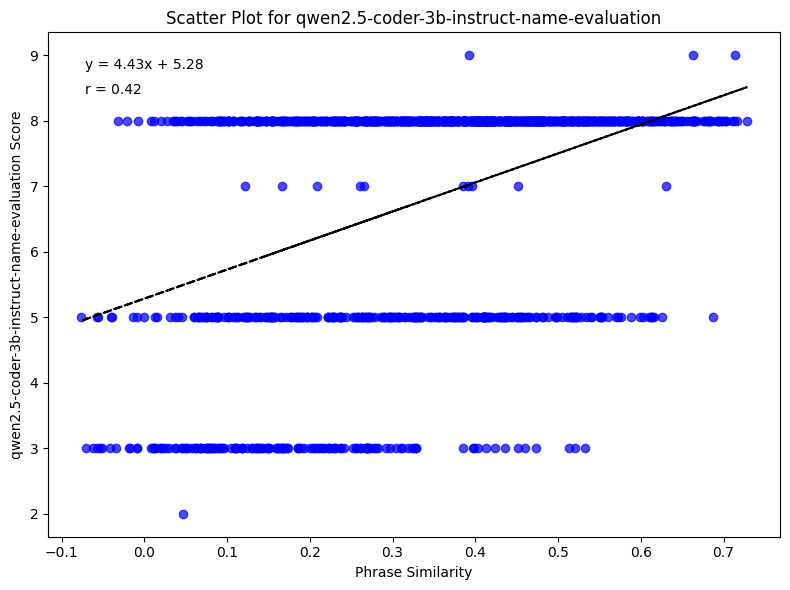

In [36]:
plot_single_scatter(results,'qwen2.5-coder-3b-instruct-name-evaluation')
# 'llama-3.2-1b-instruct-name-evaluation'
# 'gemma-2-2b-it-name-evaluation'
# 'qwen2.5-coder-3b-instruct-name-evaluation'